# Image Process and Feature Matching

Dataset in use: https://susanqq.github.io/UTKFace/

*In-the-wild Faces is used and part-2 is selected for train, part-3 is selected for test set.*

LBP için resize eklenmiştir. Değişen bir durum olmamıştır. Metrikler aşağıdaki gibidir.

In [1]:
import os
import cv2
import glob
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
from skimage import feature
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def mkdir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
            logging.debug(f"Folder '{path}' created successfully.")
        else:
            raise RuntimeError(f"Folder '{path}' already exists.")
    except Exception as e:
        logging.error(f"Error creating folder '{path}': {e} You are going to modify an existing file")
        raise

In [4]:
'''
Raporda belirtildigi gibi, girdi olarak net cekilen 1 adet yuz goruntusu verilir ve cikti olarak da gender saglanir. Bu nedenle; 

SIFT, SURF, distance vb. için tabi ki hazır fonksiyonları kullanacaksınız ama göz bulma, yüz bulma vb. işler için 
hazır kütüphane kullanamazsınız.

ibaresi proje ile alakali degildir. Projemiz yuz tespiti degil, girdi olarak verilen yuz goruntusunden gender tespitidir. 
Girdi hatasi olmasi durumunda kodun yine de calismasi amaciyla hazir kutuphane kullanilmaktadir.
'''

def face_extractor(source_dir, dest_dir, ext='jpg'):
    mkdir(dest_dir)
    haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
    
    pimgs = glob.glob(f"{source_dir}/*.{ext}")
    
    for pimg in tqdm(pimgs, desc="Cropping faces from wild images"):
        img=cv2.imread(pimg)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        faces_rect = haar_cascade.detectMultiScale(gray_img, 1.2, 5) 
        
        if faces_rect is ():
            logging.debug('No face detected')
            continue
        
        for (x, y, w, h) in faces_rect: 
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2) 
            cropped_face = gray_img[y:y+h, x:x+w]
            img_name = os.path.splitext(os.path.basename(pimg))[0]
            cv2.imwrite(f'{dest_dir}/{img_name}_cropped.jpg', cropped_face)

In [5]:
def metric_report(actual, predicted):
    acc = metrics.accuracy_score(actual, predicted)
    precision = metrics.precision_score(actual, predicted)
    recall = metrics.recall_score(actual, predicted)
    f1 = metrics.f1_score(actual, predicted)    
    return (acc, precision, recall, f1)

In [6]:
source_dir='./utk_train'
dest_dir='./utk_train_cropped'
ext='jpg'

In [7]:
test_source_dir='./utk_test'
test_dest_dir='./utk_test_cropped'

In [8]:
test_dir = './test_images'

## Local Binary Patterns

In [9]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius, r_shape=(96, 96)):
        self.numPoints = numPoints
        self.radius = radius
        self.r_shape = r_shape

    def describe(self, image, eps=1e-7):
        image = cv2.resize(image, self.r_shape)
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, self.numPoints + 3),
                                 range=(0, self.numPoints + 2))
        
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

In [10]:
def single_image_pipeline(img, desc, male_hist_path, female_hist_path):
    fimg = cv2.imread(img, 0)
    # cv2.COLOR_BGR2GRAY
    
    lbp_hist = desc.describe(fimg)
    lbp_hist = lbp_hist.astype(np.float32)

    male_lbp_hist = np.load(male_hist_path).astype(np.float32)
    female_lbp_hist = np.load(female_hist_path).astype(np.float32)

    male_distance = cv2.compareHist(lbp_hist, male_lbp_hist, cv2.HISTCMP_INTERSECT)
    female_distance = cv2.compareHist(lbp_hist, female_lbp_hist, cv2.HISTCMP_INTERSECT)    
    # HISTCMP_INTERSECT, HISTCMP_CORREL, HISTCMP_BHATTACHARYYA, HISTCMP_HELLINGER, HISTCMP_CHISQR 
    
    return 0 if male_distance >= female_distance else 1 

In [11]:
'''
UTK Train setindeki goruntulerden yuzler elde edilir ve dest_dir uzerine kaydedilir.
'''
#face_extractor(source_dir, dest_dir)

'\nUTK Train setindeki goruntulerden yuzler elde edilir ve dest_dir uzerine kaydedilir.\n'

In [12]:
'''
Elde edilen yuz goruntuleri cinsiyete gore ayristirilir.
'''

male_images=[]
female_images=[]
for pimg in tqdm(glob.glob(f"{dest_dir}/*.{ext}"), desc="Creating Male and Female Arrays"):
    img = cv2.imread(pimg, cv2.COLOR_BGR2GRAY)
    female_images.append(img) if int(os.path.basename(pimg).split('_')[1]) else male_images.append(img)


Creating Male and Female Arrays: 100%|█████████████████████████████████| 8334/8334 [00:03<00:00, 2125.35it/s]


In [13]:
#print(f'Number of male images in trainset: {len(male_images)}\nNumber of female images in trainset: {len(female_images)}')

In [14]:
desc=LocalBinaryPatterns(24, 4) # define descriptor instance

In [15]:
'''
Male-Female LBP histogramlari elde edilir ve kaydedilir. 
'''

male_histograms = [desc.describe(img) for img in tqdm(male_images, desc="Computing LBP histogram - Male")]
female_histograms = [desc.describe(img) for img in tqdm(female_images, desc="Computing LBP histogram - Female")]

male_lbp_hist = np.mean(male_histograms, axis=0)
female_lbp_hist = np.mean(female_histograms, axis=0)

np.save('male_lbp_hist_resized.npy', male_lbp_hist)
np.save('female_lbp_hist_resized.npy', female_lbp_hist)

Computing LBP histogram - Female: 100%|█████████████████████████████████| 3822/3822 [00:12<00:00, 303.03it/s]


In [16]:
#face_extractor(source_dir, dest_dir)

In [17]:
'''
Test veri setinden rastgele goruntu secilerek cinsiyet tahmini yapilir.
'''

random_image_pick = np.random.choice(glob.glob(test_dir + f'/*.{ext}'))
pred = single_image_pipeline(random_image_pick, desc, 'male_lbp_hist_resized.npy', 'female_lbp_hist_resized.npy')

In [18]:
'''
Tum test verisi uzerinde tahminler gerceklestirilir.
'''


timgs = glob.glob(f"{test_dest_dir}/*.{ext}") #test images

actual, predicted = [], []
for timg in tqdm(timgs, desc="Inference in progress"):
    gender = single_image_pipeline(timg, desc, 'male_lbp_hist_resized.npy', 'female_lbp_hist_resized.npy')  
    label = int(os.path.basename(timg).split('_')[1])
    
    actual.append(label)
    predicted.append(gender)
    

Inference in progress: 100%|████████████████████████████████████████████| 2754/2754 [00:10<00:00, 253.05it/s]


In [19]:
metric_report(actual, predicted)

(0.6278140885984024,
 0.3844714686623012,
 0.5282776349614395,
 0.44504602057390363)

In [20]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

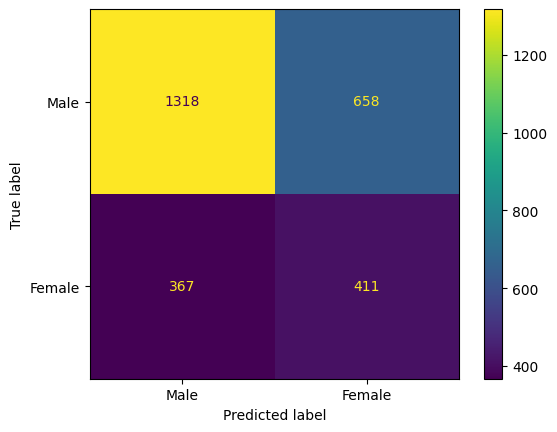

In [21]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Male', 'Female'])
cm_display.plot()
plt.show()

In [22]:
female_data = np.sum(actual); male_data = len(actual) - female_data
female_data, male_data

(778, 1976)

In [23]:
raise Exception("Eski Kod! Stop Here!")

Exception: Eski Kod! Stop Here!

## Inference of LBP

In [ ]:
# Asagidaki img_path degiskenine istenen goruntulerin pathi verilir ve lbp ile gender detect edilir.


img_path = 'test_images/22_0_0_20170119151204830_cropped.jpg'
actual = int(os.path.basename(img_path).split('_')[1])

img_path = 'arda.jpg'
actual = 0

pred = single_image_pipeline(img_path, desc, 'male_lbp_hist.npy', 'female_lbp_hist.npy')

if actual == pred:
    print('Gender Detected!')

## Scale Invariant Feature Transform (SIFT)

In [ ]:
sift = cv2.SIFT_create()

In [ ]:
def flann_match(query_descriptors, train_descriptors):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(query_descriptors, np.vstack(train_descriptors), k=2)

    # Ratio test as per Lowe's paper
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return len(good_matches)

In [ ]:
def extract_descriptors(image, extractor):
    gray = cv2.imread(image, 0)   
    keypoints, descriptors = extractor.detectAndCompute(gray, None)
    return descriptors

In [ ]:
def single_image_pipeline_sift(img, male_desc_path, female_desc_path):
    descriptor = extract_descriptors(img, sift)

    male_desc = np.load(male_desc_path).astype(np.float32)
    female_desc = np.load(female_desc_path).astype(np.float32)

    male_distance = flann_match(descriptor, male_desc)
    female_distance = flann_match(descriptor, female_desc)   
    
    return 0 if male_distance >= female_distance else 1 

In [ ]:
'''
Male-Female SIFT descriptor elde edilir. 
'''

'''
male_descriptors = []
female_descriptors = []

for img in tqdm(male_images, desc= 'Extracting descriptors - Male'):
    desc = extract_descriptors(img)
    if desc is not None:
        male_descriptors.extend(desc)

for img in tqdm(female_images, desc='Extracting descriptors - Female'):
    desc = extract_descriptors(img)
    if desc is not None:
        female_descriptors.extend(desc)
'''

In [ ]:
'''
Cikartilan descriptorlar kaydedilir.
'''

'''
male_descriptors = np.array(male_descriptors, dtype=np.float32)
female_descriptors = np.array(female_descriptors, dtype=np.float32)

np.save('male_descriptors.npy', male_descriptors)
np.save('female_descriptors.npy', female_descriptors)
'''

In [ ]:
male_descriptors = np.load('male_descriptors.npy')
female_descriptors = np.load('female_descriptors.npy')

In [ ]:
'./utk_test_cropped/'

In [ ]:
results=[]
for _ in tqdm(range(10), desc='SIFT Inference'):
    random_image_picked = np.random.choice(glob.glob(test_dir + f'/*.{ext}'), replace=False)
    img = cv2.imread(random_image_picked, 0)
    keypoints, descriptors = sift.detectAndCompute(img, None)

    male_matches = flann_match(descriptors, male_descriptors)
    female_matches = flann_match(descriptors, female_descriptors)

    predicted_gender = 0 if male_matches > female_matches else 1
    actual_gender = int(os.path.basename(random_image_picked).split('_')[1])  # Assumes filename format includes gender as second element after splitting by '_'
    
    results.append((predicted_gender, actual_gender))

for result in results:
    print(f"Predicted Gender: {'Male' if result[0] == 0 else 'Female'}, Actual Gender: {'Male' if result[1] == 0 else 'Female'}")

Compared to LBP-H algorithm implemented above, SIFT also performed same accuracy on the benchmark tests. Because of computational problems in FLANN, metrics cannot be obtained directly but sampling is used.<br>

SIFT has approximately %70 (Accuracy) on the UTK Test Set

In [ ]:
# Asagidaki img_path degiskenine istenen goruntulerin pathi verilir ve sift ile gender detect edilir.

## Inference of SIFT

In [ ]:
img_path = 'test_images/16_0_0_20170120133327900_cropped.jpg'
actual = int(os.path.basename(img_path).split('_')[1])

In [ ]:
img_path = 'arda.jpg'
actual = 0

In [ ]:
pred = single_image_pipeline_sift(img_path, 'male_descriptors.npy', 'female_descriptors.npy')

In [ ]:
if actual == pred:
    print('Gender Detected!')

Flann yerine baska bir algoritma ile daha hizli sonuclar dondurulecektir. Akabinde metrikler de gosterilecektir. Kullanilacak bazi algoritmalar 21 Mart dersinde islenmistir ve hizla koda eklenecektir.